In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib import colormaps

### 2. (10 баллов) Рассмотрим функцию распределения вида:
$$ \xi \propto \mathrm{N}(-1, \  \sigma_{-1}^2) + С_0(0, \gamma_0)  + \mathrm{N}(1, \  \sigma_{+1}^2) = \mathrm{N}(0, \  \sigma_{-1}^2 +  \sigma_{+1}^2) + С_0(0, \gamma_0)$$

Где $\mathrm{N}$ - нормальное распределение, $C_0$ - распределение Коши

##### 1. Как известно из курса теории вероятностей, плотность вероятности суммых двух случ.величин может быть найдена по формуле свертки:

$$p_{\xi} (x) = \int_{-\infty}^{\infty} p_N(y) \cdot p_C(x - y) dy = \int_{-\infty}^{\infty} \frac{1}{\sqrt{2\pi (\sigma_{-1}^2 + \sigma_{+1}^2)}} \exp (\frac{-y^2}{2(\sigma_{-1}^2 + \sigma_{+1}^2)}) \cdot \frac{1}{\pi \cdot \gamma_0} \cdot \frac{1}{1 + (x - y)^2/\gamma_0^2} dy$$

И не может быть выражена аналитически....для так называемого `Voigt profile`. Зато он реализован в `scipy.special`, чем я неприменю воспользоваться

In [2]:
from scipy.special import voigt_profile

In [3]:
pde_voigt = lambda x, sigma, gamma: voigt_profile(x, sigma, gamma)

Text(0, 0.5, '$P_\\xi(x)$')

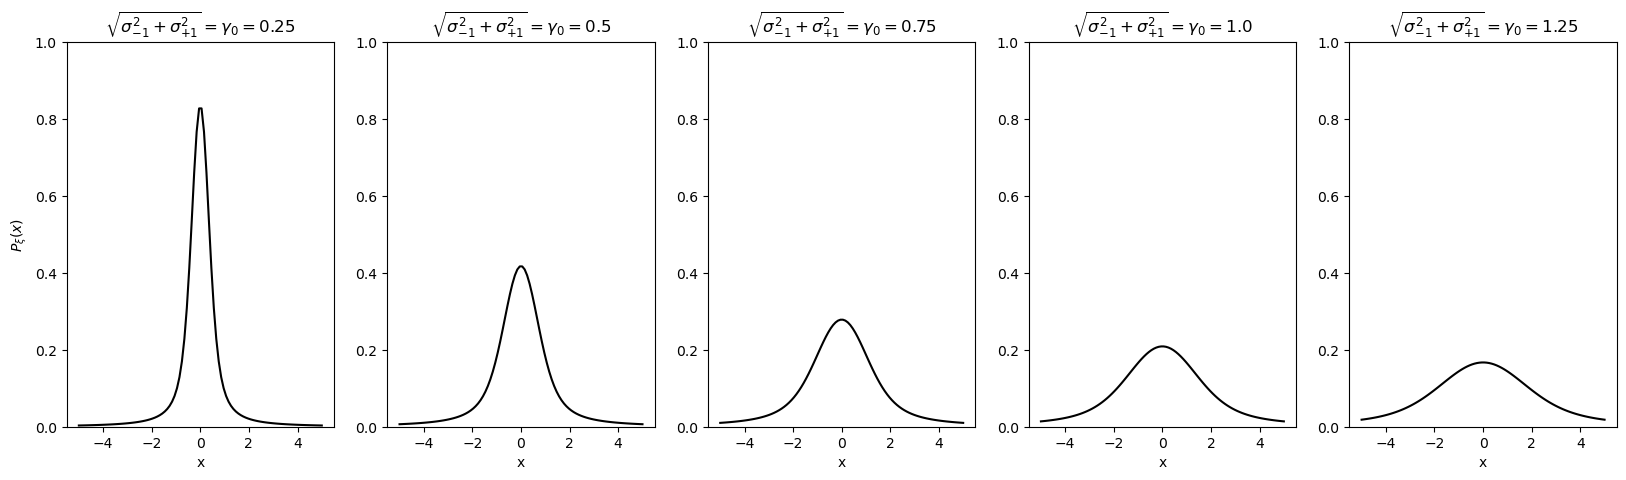

In [4]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

set_of_specs = np.arange(0.25, 1.5, 0.25)

for i, spec in enumerate(set_of_specs):
    ax[i].set_title(r'$\sqrt{\sigma_{-1}^2  +  \sigma_{+1}^2} = \gamma_0 = $' + f'{spec}')
    ax[i].plot(np.linspace(-5, 5, 100), pde_voigt(np.linspace(-5, 5, 100), spec, spec), color='blacK')
    ax[i].set_xlabel('x')
    ax[i].set_ylim(0, 1)

ax[0].set_ylabel(r'$P_\xi(x)$')

##### 2.1 Первый метод который реализуем - неэффективный метод браковки, т.к он будет показательно различаться для разных значений параметра

In [5]:
def rejection_sampling(pde, params, call=0):
    """
    Input: (pde, params, call=0):
    pde    - probability density function, function
    params - parameters to be inserted in pde
    call   - rejection sampling iteration 

    Output -> (call, x1, x2):
    call   - final number of rejection-sampling iterations
    x1     - coordinate of accepted value 
    x2     - accepted value 
    """
    x1 = np.random.uniform(-5, 5)
    x2 = np.random.uniform(0, 1)
    call  += 1
    if pde(x1, *params) > x2:
        return call, x1, x2
    else:
        return rejection_sampling(pde, params, call=call)

def sample_rejection(pde, n, params):

    return np.array([rejection_sampling(pde, params) for i in range(n)])

Text(0, 0.5, '$P_\\xi(x)$')

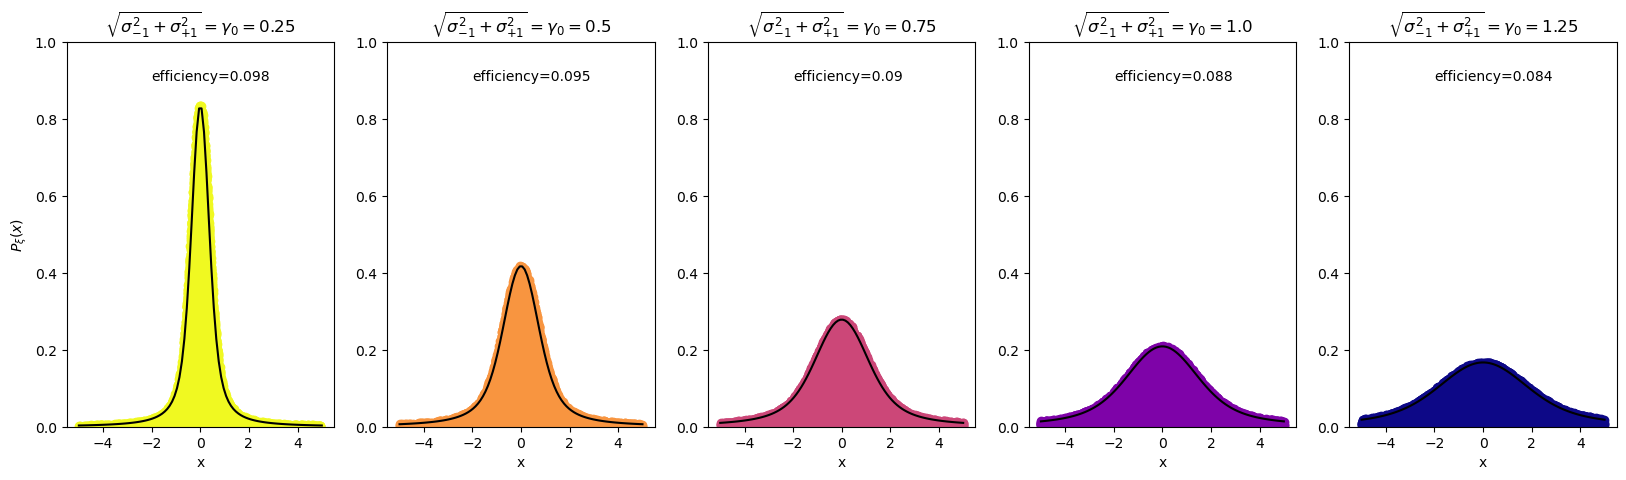

In [6]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

set_of_specs = np.arange(0.25, 1.5, 0.25)
colors = plt.cm.plasma(np.linspace(0, 1, len(set_of_specs))[::-1])

for i, spec in enumerate(set_of_specs):
    ax[i].set_title(r'$\sqrt{\sigma_{-1}^2  +  \sigma_{+1}^2}  = \gamma_0 = $' + f'{spec}')
    
    N_sampling = 10000
    points = sample_rejection(pde_voigt, N_sampling, params=(spec, spec))
    calls = points[:, 0].sum()

    ax[i].scatter(points[:,1], points[:,2], color=colors[i], label='rejection sampling')
    ax[i].text(-2, 0.9, f"efficiency={N_sampling/calls:.2}")
    ax[i].plot(np.linspace(-5, 5, 100), pde_voigt(np.linspace(-5, 5, 100), spec, spec), color='blacK')

    ax[i].set_xlabel('x')
    ax[i].set_ylim(0, 1)

ax[0].set_ylabel(r'$P_\xi(x)$')

Микровывод - увеличивая параметры и размзывая профиль ближе к 0, падаем в efficiency

##### 2.2 Второй метод founded on research - [*Lee, Jong-Sen. “Monte Carlo simulation of voigt distribution in Photon Diffusion Problems.” The Astrophysical Journal, vol. 187, Jan. 1974, p. 159*](https://adsabs.harvard.edu/full/1974ApJ...187..159L) и методе Бокса-Мюллера:

In [7]:
def voight_box_muller_sampling(bounds, params, call=0):
    """
    Input: (bounds, params, call=0):
    bounds - sampling box bounds, the only thing that limits performance, actually
    params - parameters of the Voight distribution 
    call   - rejection sampling iteration 

    Output -> (call, x1):
    call   - final number of rejection-sampling iterations
    x1     - accepted value 
    """

    call += 1

    r1 = np.random.uniform(0, 1)
    r2 = np.random.uniform(0, 1)
    r3 = np.random.uniform(0, 1)
  
    y1 = (-2*np.log(r1)) ** 0.5 * np.cos(2 * np.pi * r2) * (params[0])  
    v1 = params[1] * np.tan((r3 - 0.5) * np.pi) + y1

    if v1 <= bounds[1] and v1 >= bounds[0]:
        return call, v1
    else:
        return voight_box_muller_sampling(bounds, params, call=call)

def sample_vbml(n, bounds, params):
    return np.array([voight_box_muller_sampling(bounds, params) for i in range(n)])

Text(0, 0.5, '$P_\\xi(x)$')

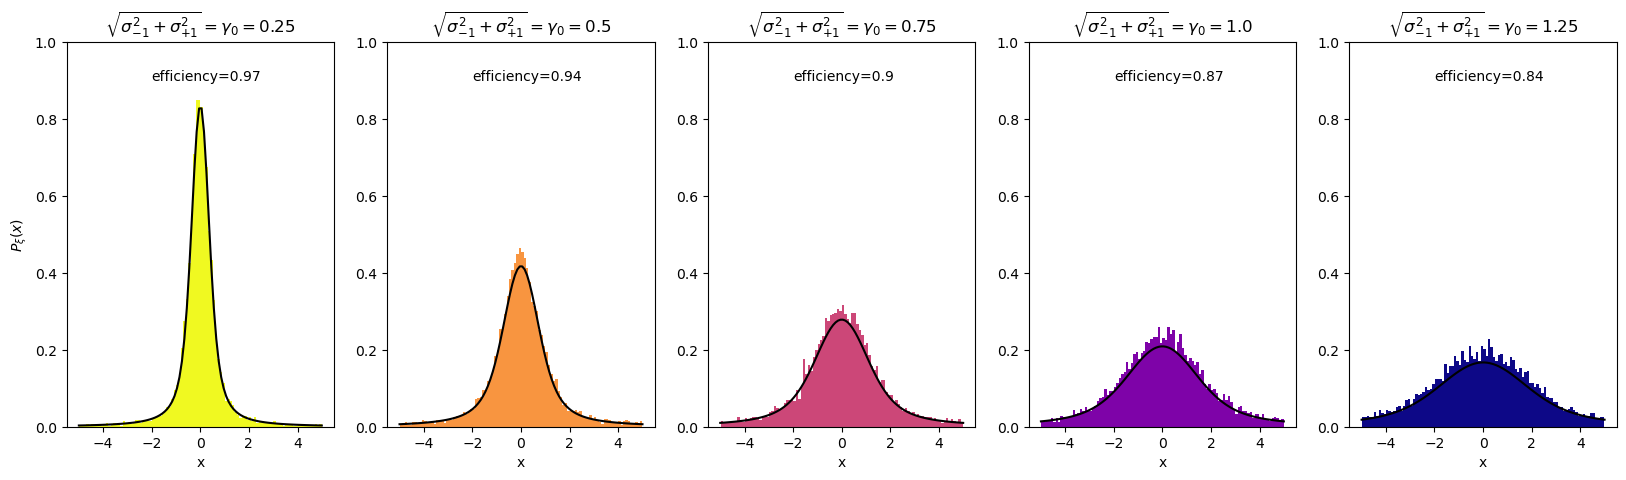

In [8]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

set_of_specs = np.arange(0.25, 1.5, 0.25)
colors = plt.cm.plasma(np.linspace(0, 1, len(set_of_specs))[::-1])

for i, spec in enumerate(set_of_specs):
    ax[i].set_title(r'$\sqrt{\sigma_{-1}^2  +  \sigma_{+1}^2}  = \gamma_0 = $' + f'{spec}')
    
    N_sampling = 10000
    points = sample_vbml(N_sampling, bounds=(-5, 5), params=(spec, spec))
    calls = points[:, 0].sum()
    
    ax[i].hist(points[:, 1], bins=100, density=True, color=colors[i], label='box-muller sampling')
    ax[i].text(-2, 0.9, f"efficiency={N_sampling/calls:.2}")
    ax[i].plot(np.linspace(-5, 5, 100), pde_voigt(np.linspace(-5, 5, 100), spec, spec), color='blacK')

    ax[i].set_xlabel('x')
    ax[i].set_ylim(0, 1)

ax[0].set_ylabel(r'$P_\xi(x)$')

Отметим, что перфоманс и "умного" сэмплера ухудшается при увелечение параметров, причем именно от роста $\gamma$, приводящего к увелечению "хвостов" распределения. Из-за этого больше точек отбрасывается при сэмплирование и растет среднее кол-во коллов $\Rightarrow$ качество падает.

### 3. (20 баллов) Рассмотрим функцию распределения вида:

$$ \rho(x, y) \propto \{ \frac{\gamma_x^{2n}}{(x - \mu_x)^{2n} + \gamma_x^{2n}} + \frac{\gamma_y^{2n}}{(x - \mu_y)^{2n} + \gamma_y^{2n}}  \}$$

##### 1. Запрограммируем ее имплементацию: 

In [139]:
def rho(x, y, mux, muy, gammax, gammay, n=1):
    x_sum = (x - mux) ** (2 * n) + gammax ** (2 * n)
    y_sum = (y - muy) ** (2 * n) + gammay ** (2 * n)
    
    return  gammax ** (2 * n) / x_sum + gammay ** (2 * n) / y_sum

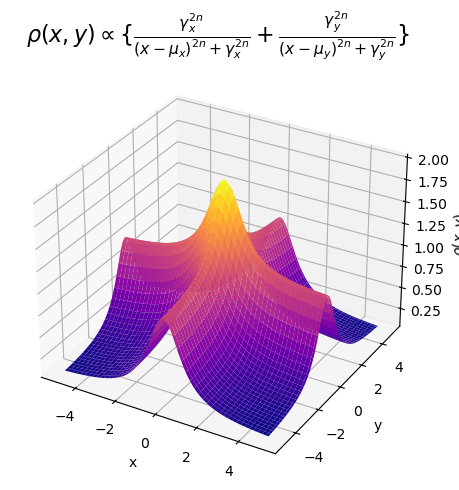

In [140]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')

X = np.linspace(-5, 5, 100)
Y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(X, Y)

Z1 = rho(X, Y, 0, 0, 1, 1, 1) 
ax.plot_surface(X, Y, Z1, cmap='plasma')


ax.set_title(r'$\rho(x, y) \propto \{\frac{\gamma_x^{2n}}{(x - \mu_x)^{2n} + \gamma_x^{2n}} + \frac{\gamma_y^{2n}}{(x - \mu_y)^{2n} + \gamma_y^{2n}}\}$', fontsize=16)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(r'$\rho(x, y)$')

plt.tight_layout()
plt.show()

##### 2. Реализуем сэмплирование распределения методом Метрополиса-Гастингса

In [168]:
def metropolis_hastings(target, n_samples=100, sigma=0.5, specs=(0, 0, 1, 1, 1), initial=(0, 0)):
    samples  = np.zeros((n_samples, 2))
    current  = np.array(initial, dtype=np.float64)
    accepted = 0

    for i in range(n_samples):
        proposal = current + np.random.normal(0, sigma, 2)
        prob = target(*proposal, *specs) / target(*current, *specs)
        if np.random.rand() < prob:
            current = proposal
            accepted += 1
        samples[i] = current

    print(f"Metropolis-Hastings Acceptance rate: {accepted / n_samples:.2f}")
    return samples

In [173]:
n_samples = 10000
burn_in   = 1000
samples_mh = metropolis_hastings(rho, n_samples, sigma=0.5)
samples_mh = samples_mh[burn_in:]

Metropolis-Hastings Acceptance rate: 0.93


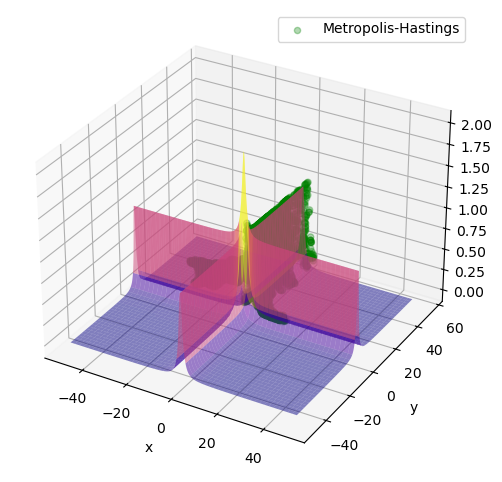

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')


X = np.linspace(-50, 50, 1000)
Y = np.linspace(-50, 50, 1000)
X, Y = np.meshgrid(X, Y)

Z1 = rho(X, Y, 0, 0, 1, 1, 1) 
ax.plot_surface(X, Y, Z1, cmap='plasma', alpha=0.5)

ax.scatter(samples_mh[:, 0], 
           samples_mh[:, 1], 
           rho(samples_mh[:, 0], samples_mh[:, 1], *(0, 0, 1, 1, 1)),
           color='green', alpha=0.3, label='Metropolis-Hastings')

ax.set_xlabel('x')
ax.set_ylabel('y')

plt.legend()
plt.show();

##### 2. Реализуем сэмплирование распределения методом Гамильтонова Монте-Карло

In [183]:
def hamiltonian_monte_carlo(target, n_samples, step_size=0.01, n_steps=10, specs=(0, 0, 1, 1, 1), initial=(0, 0)):
    def U(q):
        return -np.log(target(q[0], q[1], *specs)) + 1e-16  
    
    def grad_U(q, h=1e-5):
        dUdx = (U([q[0] + h, q[1]]) - U([q[0] - h, q[1]])) / (2 * h)
        dUdy = (U([q[0], q[1] + h]) - U([q[0], q[1] - h])) / (2 * h)
        return np.array([dUdx, dUdy], dtype=np.float64)
    
    samples = np.zeros((n_samples, 2), dtype=np.float64)
    current = np.array(initial, dtype=np.float64)
    accepted = 0
    for i in range(n_samples):
        q = current.copy()
        p = np.random.normal(0, 1, 2)  
        current_p = p.copy()
        
        # Leapfrog 
        p -= step_size * grad_U(q) / 2
        for _ in range(n_steps):
            q += step_size * p
            p -= step_size * grad_U(q)
        p -= step_size * grad_U(q) / 2
        
        # Metropolis acceptance
        current_U  = U(current)
        current_K  = 0.5 * np.sum(current_p**2)
        proposed_U = U(q)
        proposed_K = 0.5 * np.sum(p**2)
        
        if np.random.rand() < np.exp(current_U - proposed_U + current_K - proposed_K):
            current = q
            accepted += 1
        samples[i] = current
        
    print(f"Hamiltionian Acceptance rate: {accepted / n_samples:.2f}")
    return samples

samples_hmc = hamiltonian_monte_carlo(rho, n_samples, step_size=0.01, n_steps=10)
samples_hmc = samples_hmc[burn_in:]

Hamiltionian Acceptance rate: 1.00


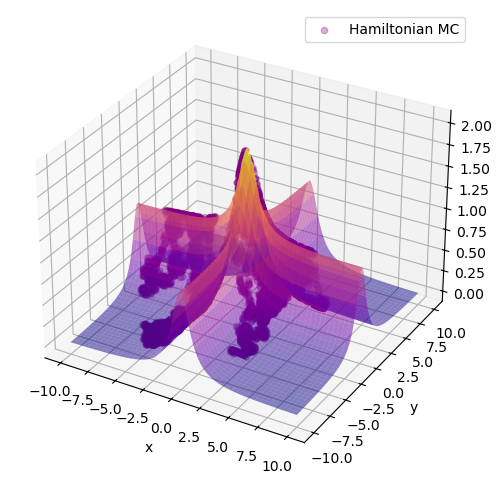

In [194]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')


X = np.linspace(-10, 10, 1000)
Y = np.linspace(-10, 10, 1000)
X, Y = np.meshgrid(X, Y)

Z1 = rho(X, Y, 0, 0, 1, 1, 1) 
ax.plot_surface(X, Y, Z1, cmap='plasma', alpha=0.5)


ax.scatter(samples_hmc[:, 0], 
           samples_hmc[:, 1], 
           rho(samples_hmc[:, 0], samples_hmc[:, 1], *(0, 0, 1, 1, 1)),
            c='purple', alpha=0.3, label='Hamiltonian MC')


ax.set_xlabel('x')
ax.set_ylabel('y')

plt.legend()
plt.show();



##### 4. Анализ результатов

In [188]:
def autocorrelation(samples, max_lag=50):
    acf = np.zeros(max_lag)

    for lag in range(max_lag):
        acf[lag] = np.corrcoef(samples[:-lag], samples[lag:])[0, 1] if lag != 0 else 1.0
    return acf

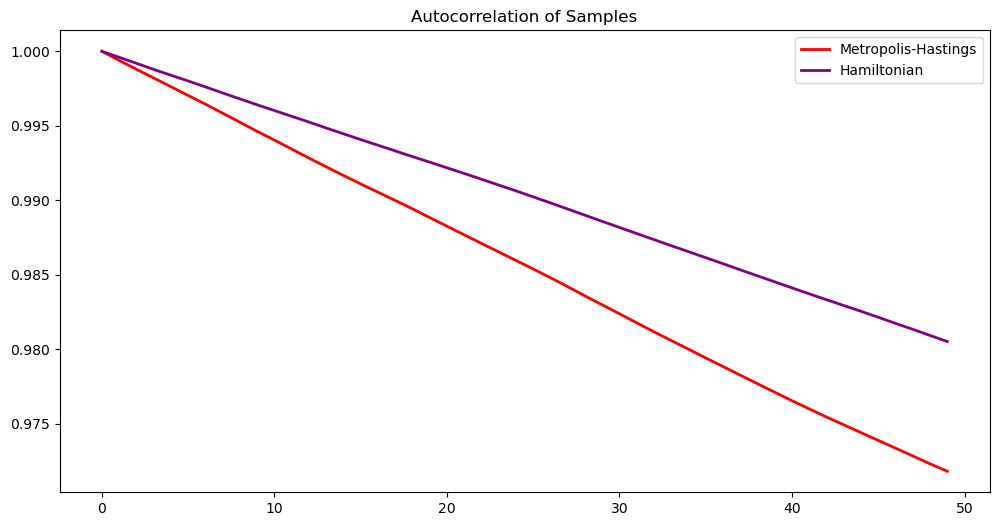

In [195]:
plt.figure(figsize=(12, 6))
plt.plot(autocorrelation(samples_mh[:, 0]), label='Metropolis-Hastings', lw=2, color='red')
plt.plot(autocorrelation(samples_hmc[:, 0]), label='Hamiltonian', lw=2, color='purple')
plt.title('Autocorrelation of Samples')
plt.legend()
plt.show()